## Resnet from scratch

Just trying to build resnet from scratch on my own without peeking as much as possible.

## Import libraries

This is an exception :)

In [7]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.xtras import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [8]:
dls = get_dls()
xb, yb = next(iter(dls.train))
xb.shape, yb

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4,  ..., 8, 0, 3]))

## Convolutional net

Let's start with a conv net and go from there.

In [36]:
act_gr = partial(GeneralRelu, leak=0.15, sub=0.37)
iw = partial(init_weights, leaky=0.15)

nfs = [1,8,16,32,64,128]
def get_model():
    layers = [conv(nfs[i], nfs[i+1], act=gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
def print_shapes(hook, ):

In [20]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  100026


|Module|Input|Output|Num params|
|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 8, 14, 14)|96|
|Sequential|(1024, 8, 14, 14)|(1024, 16, 7, 7)|1200|
|Sequential|(1024, 16, 7, 7)|(1024, 32, 4, 4)|4704|
|Sequential|(1024, 32, 4, 4)|(1024, 64, 2, 2)|18624|
|Sequential|(1024, 64, 2, 2)|(1024, 128, 1, 1)|74112|
|AdaptiveAvgPool2d|(1024, 128, 1, 1)|(1024, 128, 1, 1)|0|
|Flatten|(1024, 128, 1, 1)|(1024, 128)|0|
|Linear|(1024, 128)|(1024, 10)|1290|


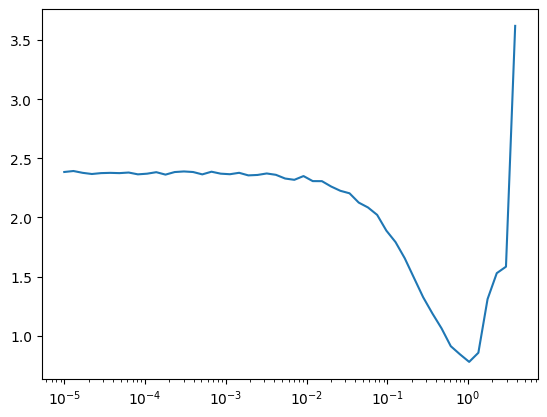

In [21]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

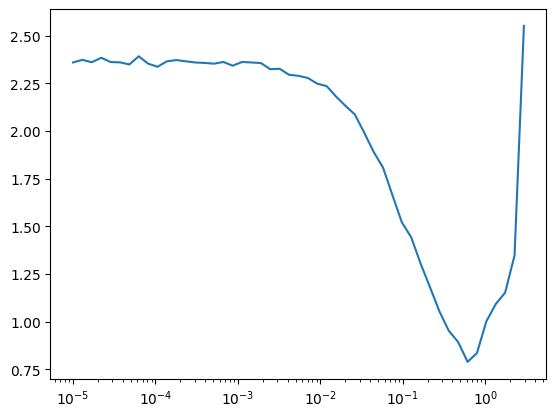

In [39]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()